In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
import torch
from torch import nn, optim, no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from matplotlib.pyplot import imshow
from time import time
from sklearn.metrics import f1_score as f1

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
MNIST_treino = datasets.MNIST('./', train = True, transform = transforms.ToTensor(), download=True)
MNIST_teste =  datasets.MNIST('./', train = False, transform = transforms.ToTensor(), download=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 103492191.84it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 114603305.42it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27109023.40it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20440481.51it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
print(len(MNIST_treino), len(MNIST_teste))

60000 10000


  # Explorando o conjunto de dados

In [ ]:
type(MNIST_teste)

torchvision.datasets.mnist.MNIST

In [ ]:
MNIST_teste[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
type(MNIST_teste[0])

tuple

In [ ]:
type(MNIST_teste[0][0])

torch.Tensor

In [ ]:
len(MNIST_teste[0][0])

1

In [ ]:
MNIST_teste[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
MNIST_teste[0][0][0].shape

torch.Size([28, 28])

In [ ]:
MNIST_teste[0][0][0].shape[0]

28

In [ ]:
MNIST_teste[0][0][0].shape[0] * MNIST_teste[0][0][0].shape[1]

784

3


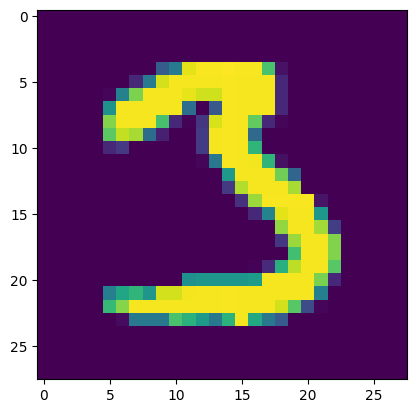

In [ ]:
imagem, rotulo = MNIST_treino[11111]

imshow(imagem[0])
print(rotulo)

# Hiperparâmetros

In [59]:
args = {
    'batch_size':       5,    #quantidade de amostras por iteração
    'num_threads':      4,    #número de threads do DataLoader
    #número real de batches = 20 (tamanho de cada batch * quantidade de threads)
    'num_classes':      len(MNIST_teste.classes),
    'taxa_aprendizado': 1e-4, #
    'weight_decay':     5e-4, #
    'num_epochs':       30    #
}
neurons = {
    'input_size':   1 * 28 * 28, #dimensão de entrada (imagens de 28x28 bits com 1 canal de cor. precisa ser achatado para uma única dimensão)
    'hidden_size':  128, # dimensão escondida, hiperparâmetro
    'out_size':     args['num_classes']
}

# Importando dados

In [49]:
treino_loader = DataLoader(MNIST_treino,
                          batch_size = args['batch_size'],
                          shuffle = True,
                          num_workers = args['num_threads'])

teste_loader = DataLoader(MNIST_teste,
                          batch_size = args['batch_size'],
                          shuffle = True,
                          num_workers = args['num_threads'])


# Criando rede

In [ ]:
class MNIST_MLP(nn.Module):
  #Definição da nossa própria multi-layered perceptron
  def __init__(self, input_size, hidden_size, out_size):
    super(MNIST_MLP, self).__init__()

    #Definição das camadas e das funções de ativação intermediárias
    # aqui escolhemos duas redes lineares e como funções de ativação, ReLU duas vezes
    self.features  = nn.Sequential(
                        nn.Linear(input_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU())
    #A de saída também será linear
    self.out     = nn.Linear(hidden_size, out_size)
    self.softmax = nn.Softmax()
    #Como estamos lidando com um processo de classificação, passaremos por um softmax

  def forward(self, input):
    #Define a computação de cada chamada
    input = input.view(input.size(0), -1) #Linearizando a entrada

    feature = self.features(input)
    output  = self.softmax(self.out(feature))

    return output


In [ ]:
rede = MNIST_MLP(neurons['input_size'], neurons['hidden_size'], neurons['out_size']).to('cuda')
print(rede)

MNIST_MLP(
  (features): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (out): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)


In [ ]:
criterion = nn.CrossEntropyLoss().to('cuda') #CrossEntropy indicado para classificação multiclasses

In [55]:
optimizer = optim.Adam(rede.parameters(), lr=args['taxa_aprendizado'], weight_decay=args['weight_decay'])
#Pesquisar sobre pq Adam (sei leigamente que é mt bom)

In [56]:
def treina(train_set, rede, num_epochs):
  rede.train() #modo treino

  start = time()

  epoch_loss = []
  for batch in train_set:

    dado, rotulo = batch

    dado = dado.to('cuda')
    rotulo = rotulo.to('cuda')

    # Forward
    pred = rede(dado)
    loss = criterion(pred, rotulo)
    epoch_loss.append(loss.cpu().item())

    # Backward
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  end = time()

  print("Época %d, Loss: %.4f +\- %.4f, Tempo: %.2f" % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

  return epoch_loss.mean()


In [57]:
def valida(teste_set, rede, num_epochs):
  rede.eval() #modo avaliação

  start = time()

  epoch_loss = []
  # y_true = []
  # y_pred = []

  with no_grad():

    for batch in teste_set:

      dado, rotulo = batch

      dado = dado.to('cuda')
      rotulo = rotulo.to('cuda')

      # Forward
      pred = rede(dado)
      loss = criterion(pred, rotulo)
      epoch_loss.append(loss.cpu().item())

      # y_true.extend(rotulo.cpu().numpy())
      # y_pred.extend(pred.cpu().numpy())

    epoch_loss = np.asarray(epoch_loss)
    # f1 = f1(y_true, y_pred)
    end = time()

    print("Época %d, Loss: %.4f +\- %.4f, Tempo: %.2f" % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

  return epoch_loss.mean()

# Execução

In [58]:
treino_loss, teste_loss, f1, ROC = [], [], [], []
for epoch in range(args['num_epochs']):

  # Train
  treino_loss.append(treina(treino_loader, rede, args['num_epochs']))

  # Validate
  teste_loss.append(valida(teste_loader, rede, args['num_epochs']))

Época 0, Loss: 2.3638 +\- 0.1316, Tempo: 46.69
Época 0, Loss: 2.3630 +\- 0.1334, Tempo: 5.39
Época 1, Loss: 2.3638 +\- 0.1324, Tempo: 47.75
Época 1, Loss: 2.3630 +\- 0.1305, Tempo: 4.98


KeyboardInterrupt: ignored